In [1]:
import os
import math

import cv2

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
datafiles = os.listdir("imgs")

train_files, valid_files = train_test_split(datafiles, train_size=0.8)
print(len(train_files), len(valid_files))

16401 4101


C:\Users\du0x\Anaconda2\envs\tfgpu\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
def load_img(filename):
    img = cv2.imread(filename)
    img = img[:300,:300,:]
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), axis=2)
    
    #Remove aim (network was taking conclusion based on it, I am color blind so I did not realize the aim changes color)
    #aim_thickness = 1
    #aim_length = 16
    #debug_img[150-offset:150+offset, 150-offset:150+offset, :] = 0
    #img[150-aim_length:150+aim_length, 150-aim_thickness:150+aim_thickness, :] = 0
    #img[150-aim_thickness:150+aim_thickness, 150-aim_length:150+aim_length, :] = 0
    
    return img, int(filename[5] == 'p')

In [4]:
#plt.imshow(load_img("imgs/" + train_files[0])[0])

In [5]:
def get_image_batches(files_list, batch_size):
    for i in range(0, len(files_list), batch_size):
        x_batch, y_batch = list(zip(*[load_img("imgs/" + filename) for filename in files_list[i:i+batch_size]]))
        x_batch = np.array(x_batch)
        yield x_batch, y_batch
        
#x_batch, y_batch = next(get_image_batches(train_files, 10))
#print(x_batch.shape)
#print(y_batch)

In [6]:
def create_inputs():
    inputs = tf.placeholder(shape=[None, 300, 300, 3], dtype=tf.float32)
    targets = tf.placeholder(shape=[None], dtype=tf.float32)
    
    return inputs, targets

In [7]:
def create_conv_net(image_batch, reuse=False):
    with tf.variable_scope("conv_net", reuse=reuse):
        
        image_batch /= 255 #Normalize image data
        
        conv1 = tf.layers.conv2d(image_batch, filters=8, kernel_size=[5,5], strides=[1, 1], padding='SAME',
                                kernel_initializer=None, bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu)
        conv1 = tf.layers.max_pooling2d(conv1, pool_size=[5,5], strides=[2,2], padding='SAME')
        #print(conv1.get_shape())
        
        conv2 = tf.layers.conv2d(conv1, filters=16, kernel_size=[3,3], strides=[1, 1], padding='SAME',
                                kernel_initializer=None, bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu)
        conv2 = tf.layers.max_pooling2d(conv2, pool_size=[3,3], strides=[2,2], padding='SAME')
        #print(conv2.get_shape())
        
        conv3 = tf.layers.conv2d(conv2, filters=32, kernel_size=[3,3], strides=[1, 1], padding='SAME',
                                kernel_initializer=None, bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu)
        conv3 = tf.layers.max_pooling2d(conv3, pool_size=[3,3], strides=[2,2], padding='SAME')
        #print(conv3.get_shape())
        
        conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size=[3,3], strides=[1, 1], padding='SAME',
                                kernel_initializer=None, bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu)
        conv4 = tf.layers.max_pooling2d(conv4, pool_size=[3,3], strides=[2,2], padding='SAME')
        #print(conv4.get_shape())
        
        conv5 = tf.layers.conv2d(conv4, filters=128, kernel_size=[3,3], strides=[1, 1], padding='SAME',
                                kernel_initializer=None, bias_initializer=tf.zeros_initializer(), activation=tf.nn.relu)
        conv5 = tf.layers.max_pooling2d(conv5, pool_size=[3,3], strides=[2,2], padding='SAME')
        #print(conv5.get_shape())

        flatten_layer = tf.layers.flatten(conv5)
        
        h1 = tf.layers.dense(flatten_layer, 5000, tf.nn.relu)
        h2 = tf.layers.dense(h1, 1000, tf.nn.relu)
        h3 = tf.layers.dense(h2, 256, tf.nn.relu)
        
        logits = tf.squeeze(tf.layers.dense(h3, 1), axis=1)
        
        outputs = tf.nn.sigmoid(logits)
        
        return logits, outputs
    

In [8]:
def create_optimizer(logits, labels, learning_rate=0.001):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    return optimizer, loss

In [9]:
def create_perform_metrics(outputs, labels):
    
    outputs = tf.cast(outputs > 0.5, tf.bool)
    labels = tf.cast(labels, tf.bool)
    
    acc, acc_update = tf.metrics.accuracy(outputs, labels)
    recall, recall_update = tf.metrics.recall(outputs, labels)
    
    return acc_update, recall_update

def reset_metrics_variables():
    return [tf.assign(v,0) for v in tf.local_variables() if 'accuracy' in v.name or 'recall' in v.name]

In [10]:
notpressed_ratio = len([f for f in valid_files if 'not' in f]) / len(valid_files)
print(notpressed_ratio)

0.7868812484759815


In [11]:
N_EPOCHS = 10

BATCH_SIZE = 64

n_batches = math.ceil(len(train_files) / BATCH_SIZE)

#-------------------------------------------------#

tf.reset_default_graph()

inputs, targets = create_inputs()

logits, outputs = create_conv_net(inputs)
optimizer, loss = create_optimizer(logits, targets, 0.001)

#valid_logits, valid_outputs = create_conv_net(valid_dataset_x_batch, reuse=True)
metrics_update = create_perform_metrics(outputs, targets)
reset_metrics = reset_metrics_variables()

saver = tf.train.Saver()

print("Initializing session...")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for e in range(N_EPOCHS):
        #train_files, valid_files
        
        i_batch = 0
        
        for x_batch, y_batch in get_image_batches(train_files, BATCH_SIZE):
            
            i_batch += 1
    
            _, loss_value = sess.run([optimizer, loss], feed_dict={
                inputs: x_batch,
                targets: y_batch
            })
        
            print("Epoch {}/{} \t Batch {}/{} \t Loss: {}".format(e+1, N_EPOCHS, i_batch, n_batches, loss_value))
            
            
        print("Calculating performance...")
        sess.run(reset_metrics)
        for valid_x_batch, valid_y_batch in get_image_batches(valid_files, BATCH_SIZE):
    
            acc_loss_value = sess.run(loss, feed_dict={
                inputs: valid_x_batch,
                targets: valid_y_batch
            })
    
            acc_value, recall_value = sess.run(metrics_update, feed_dict={
                inputs: valid_x_batch,
                targets: valid_y_batch
            })
        
        print("Accuracy: {} \t Recall: {} \t Loss: {}".format(acc_value, recall_value, acc_loss_value))
        
        saver.save(sess, "checkpoints/model.ckpt")

Initializing session...
Epoch 1/10 	 Batch 1/257 	 Loss: 0.6882324814796448
Epoch 1/10 	 Batch 2/257 	 Loss: 2.243445873260498
Epoch 1/10 	 Batch 3/257 	 Loss: 0.5978450179100037
Epoch 1/10 	 Batch 4/257 	 Loss: 0.6029296517372131
Epoch 1/10 	 Batch 5/257 	 Loss: 0.5135822296142578
Epoch 1/10 	 Batch 6/257 	 Loss: 0.619162917137146
Epoch 1/10 	 Batch 7/257 	 Loss: 0.5693265199661255
Epoch 1/10 	 Batch 8/257 	 Loss: 0.5698220133781433
Epoch 1/10 	 Batch 9/257 	 Loss: 0.5363755226135254
Epoch 1/10 	 Batch 10/257 	 Loss: 0.5933892130851746
Epoch 1/10 	 Batch 11/257 	 Loss: 0.6698011159896851
Epoch 1/10 	 Batch 12/257 	 Loss: 0.5546694993972778
Epoch 1/10 	 Batch 13/257 	 Loss: 0.5856306552886963
Epoch 1/10 	 Batch 14/257 	 Loss: 0.5567896366119385
Epoch 1/10 	 Batch 15/257 	 Loss: 0.5427843332290649
Epoch 1/10 	 Batch 16/257 	 Loss: 0.5311219692230225
Epoch 1/10 	 Batch 17/257 	 Loss: 0.4599670171737671
Epoch 1/10 	 Batch 18/257 	 Loss: 0.6554877758026123
Epoch 1/10 	 Batch 19/257 	 Loss:

Epoch 1/10 	 Batch 154/257 	 Loss: 0.3719724118709564
Epoch 1/10 	 Batch 155/257 	 Loss: 0.3611178398132324
Epoch 1/10 	 Batch 156/257 	 Loss: 0.37260156869888306
Epoch 1/10 	 Batch 157/257 	 Loss: 0.3369092345237732
Epoch 1/10 	 Batch 158/257 	 Loss: 0.6421159505844116
Epoch 1/10 	 Batch 159/257 	 Loss: 0.3939768373966217
Epoch 1/10 	 Batch 160/257 	 Loss: 0.5346609354019165
Epoch 1/10 	 Batch 161/257 	 Loss: 0.4576912522315979
Epoch 1/10 	 Batch 162/257 	 Loss: 0.5000430345535278
Epoch 1/10 	 Batch 163/257 	 Loss: 0.32350364327430725
Epoch 1/10 	 Batch 164/257 	 Loss: 0.42957085371017456
Epoch 1/10 	 Batch 165/257 	 Loss: 0.5210605263710022
Epoch 1/10 	 Batch 166/257 	 Loss: 0.3434528112411499
Epoch 1/10 	 Batch 167/257 	 Loss: 0.43953371047973633
Epoch 1/10 	 Batch 168/257 	 Loss: 0.4736056327819824
Epoch 1/10 	 Batch 169/257 	 Loss: 0.41227954626083374
Epoch 1/10 	 Batch 170/257 	 Loss: 0.3983680009841919
Epoch 1/10 	 Batch 171/257 	 Loss: 0.5942145586013794
Epoch 1/10 	 Batch 172/

Epoch 2/10 	 Batch 47/257 	 Loss: 0.3677750825881958
Epoch 2/10 	 Batch 48/257 	 Loss: 0.4222487807273865
Epoch 2/10 	 Batch 49/257 	 Loss: 0.46041712164878845
Epoch 2/10 	 Batch 50/257 	 Loss: 0.39110520482063293
Epoch 2/10 	 Batch 51/257 	 Loss: 0.39610162377357483
Epoch 2/10 	 Batch 52/257 	 Loss: 0.32064104080200195
Epoch 2/10 	 Batch 53/257 	 Loss: 0.5646714568138123
Epoch 2/10 	 Batch 54/257 	 Loss: 0.3953174352645874
Epoch 2/10 	 Batch 55/257 	 Loss: 0.35093963146209717
Epoch 2/10 	 Batch 56/257 	 Loss: 0.3773847222328186
Epoch 2/10 	 Batch 57/257 	 Loss: 0.48825544118881226
Epoch 2/10 	 Batch 58/257 	 Loss: 0.37975090742111206
Epoch 2/10 	 Batch 59/257 	 Loss: 0.3907232880592346
Epoch 2/10 	 Batch 60/257 	 Loss: 0.45153602957725525
Epoch 2/10 	 Batch 61/257 	 Loss: 0.4291312098503113
Epoch 2/10 	 Batch 62/257 	 Loss: 0.4511670470237732
Epoch 2/10 	 Batch 63/257 	 Loss: 0.3649519681930542
Epoch 2/10 	 Batch 64/257 	 Loss: 0.2334165871143341
Epoch 2/10 	 Batch 65/257 	 Loss: 0.46

Epoch 2/10 	 Batch 199/257 	 Loss: 0.3095245063304901
Epoch 2/10 	 Batch 200/257 	 Loss: 0.3270495533943176
Epoch 2/10 	 Batch 201/257 	 Loss: 0.4042263627052307
Epoch 2/10 	 Batch 202/257 	 Loss: 0.25608378648757935
Epoch 2/10 	 Batch 203/257 	 Loss: 0.44683289527893066
Epoch 2/10 	 Batch 204/257 	 Loss: 0.4304438829421997
Epoch 2/10 	 Batch 205/257 	 Loss: 0.26003697514533997
Epoch 2/10 	 Batch 206/257 	 Loss: 0.3156828284263611
Epoch 2/10 	 Batch 207/257 	 Loss: 0.3631451725959778
Epoch 2/10 	 Batch 208/257 	 Loss: 0.29056406021118164
Epoch 2/10 	 Batch 209/257 	 Loss: 0.337532103061676
Epoch 2/10 	 Batch 210/257 	 Loss: 0.2876434624195099
Epoch 2/10 	 Batch 211/257 	 Loss: 0.4219508171081543
Epoch 2/10 	 Batch 212/257 	 Loss: 0.39001262187957764
Epoch 2/10 	 Batch 213/257 	 Loss: 0.3210335373878479
Epoch 2/10 	 Batch 214/257 	 Loss: 0.20717479288578033
Epoch 2/10 	 Batch 215/257 	 Loss: 0.30700698494911194
Epoch 2/10 	 Batch 216/257 	 Loss: 0.2723795175552368
Epoch 2/10 	 Batch 217

Epoch 3/10 	 Batch 93/257 	 Loss: 0.24851563572883606
Epoch 3/10 	 Batch 94/257 	 Loss: 0.353054404258728
Epoch 3/10 	 Batch 95/257 	 Loss: 0.42957547307014465
Epoch 3/10 	 Batch 96/257 	 Loss: 0.309474378824234
Epoch 3/10 	 Batch 97/257 	 Loss: 0.44579899311065674
Epoch 3/10 	 Batch 98/257 	 Loss: 0.26745206117630005
Epoch 3/10 	 Batch 99/257 	 Loss: 0.3069326877593994
Epoch 3/10 	 Batch 100/257 	 Loss: 0.2942889928817749
Epoch 3/10 	 Batch 101/257 	 Loss: 0.3340647220611572
Epoch 3/10 	 Batch 102/257 	 Loss: 0.23239699006080627
Epoch 3/10 	 Batch 103/257 	 Loss: 0.3467009365558624
Epoch 3/10 	 Batch 104/257 	 Loss: 0.4397616386413574
Epoch 3/10 	 Batch 105/257 	 Loss: 0.2901604473590851
Epoch 3/10 	 Batch 106/257 	 Loss: 0.45659205317497253
Epoch 3/10 	 Batch 107/257 	 Loss: 0.3197230100631714
Epoch 3/10 	 Batch 108/257 	 Loss: 0.287980854511261
Epoch 3/10 	 Batch 109/257 	 Loss: 0.2734312415122986
Epoch 3/10 	 Batch 110/257 	 Loss: 0.3064267039299011
Epoch 3/10 	 Batch 111/257 	 Los

Epoch 3/10 	 Batch 244/257 	 Loss: 0.32630181312561035
Epoch 3/10 	 Batch 245/257 	 Loss: 0.30499428510665894
Epoch 3/10 	 Batch 246/257 	 Loss: 0.42367231845855713
Epoch 3/10 	 Batch 247/257 	 Loss: 0.2871072292327881
Epoch 3/10 	 Batch 248/257 	 Loss: 0.2981855273246765
Epoch 3/10 	 Batch 249/257 	 Loss: 0.3752809166908264
Epoch 3/10 	 Batch 250/257 	 Loss: 0.3187043070793152
Epoch 3/10 	 Batch 251/257 	 Loss: 0.3085639178752899
Epoch 3/10 	 Batch 252/257 	 Loss: 0.2827601730823517
Epoch 3/10 	 Batch 253/257 	 Loss: 0.43385177850723267
Epoch 3/10 	 Batch 254/257 	 Loss: 0.3082503080368042
Epoch 3/10 	 Batch 255/257 	 Loss: 0.3449709713459015
Epoch 3/10 	 Batch 256/257 	 Loss: 0.2695923447608948
Epoch 3/10 	 Batch 257/257 	 Loss: 0.18903253972530365
Calculating performance...
Accuracy: 0.8663740754127502 	 Recall: 0.790035605430603 	 Loss: 0.7385976910591125
Epoch 4/10 	 Batch 1/257 	 Loss: 0.30247461795806885
Epoch 4/10 	 Batch 2/257 	 Loss: 0.29442131519317627
Epoch 4/10 	 Batch 3/2

Epoch 4/10 	 Batch 138/257 	 Loss: 0.22948111593723297
Epoch 4/10 	 Batch 139/257 	 Loss: 0.2811165153980255
Epoch 4/10 	 Batch 140/257 	 Loss: 0.28562700748443604
Epoch 4/10 	 Batch 141/257 	 Loss: 0.3737587332725525
Epoch 4/10 	 Batch 142/257 	 Loss: 0.1977553814649582
Epoch 4/10 	 Batch 143/257 	 Loss: 0.29701417684555054
Epoch 4/10 	 Batch 144/257 	 Loss: 0.38133272528648376
Epoch 4/10 	 Batch 145/257 	 Loss: 0.2808167636394501
Epoch 4/10 	 Batch 146/257 	 Loss: 0.2604420483112335
Epoch 4/10 	 Batch 147/257 	 Loss: 0.15839624404907227
Epoch 4/10 	 Batch 148/257 	 Loss: 0.19871175289154053
Epoch 4/10 	 Batch 149/257 	 Loss: 0.21788419783115387
Epoch 4/10 	 Batch 150/257 	 Loss: 0.16176775097846985
Epoch 4/10 	 Batch 151/257 	 Loss: 0.44506722688674927
Epoch 4/10 	 Batch 152/257 	 Loss: 0.3098390996456146
Epoch 4/10 	 Batch 153/257 	 Loss: 0.24434654414653778
Epoch 4/10 	 Batch 154/257 	 Loss: 0.2578212022781372
Epoch 4/10 	 Batch 155/257 	 Loss: 0.3057674765586853
Epoch 4/10 	 Batch

Epoch 5/10 	 Batch 31/257 	 Loss: 0.356553852558136
Epoch 5/10 	 Batch 32/257 	 Loss: 0.4007103443145752
Epoch 5/10 	 Batch 33/257 	 Loss: 0.26644375920295715
Epoch 5/10 	 Batch 34/257 	 Loss: 0.16446053981781006
Epoch 5/10 	 Batch 35/257 	 Loss: 0.24086320400238037
Epoch 5/10 	 Batch 36/257 	 Loss: 0.32240599393844604
Epoch 5/10 	 Batch 37/257 	 Loss: 0.36528342962265015
Epoch 5/10 	 Batch 38/257 	 Loss: 0.31822383403778076
Epoch 5/10 	 Batch 39/257 	 Loss: 0.1821049004793167
Epoch 5/10 	 Batch 40/257 	 Loss: 0.43266594409942627
Epoch 5/10 	 Batch 41/257 	 Loss: 0.3028128147125244
Epoch 5/10 	 Batch 42/257 	 Loss: 0.23386529088020325
Epoch 5/10 	 Batch 43/257 	 Loss: 0.25242000818252563
Epoch 5/10 	 Batch 44/257 	 Loss: 0.29811418056488037
Epoch 5/10 	 Batch 45/257 	 Loss: 0.2997211217880249
Epoch 5/10 	 Batch 46/257 	 Loss: 0.3439936637878418
Epoch 5/10 	 Batch 47/257 	 Loss: 0.33415594696998596
Epoch 5/10 	 Batch 48/257 	 Loss: 0.32789793610572815
Epoch 5/10 	 Batch 49/257 	 Loss: 0

Epoch 5/10 	 Batch 183/257 	 Loss: 0.26928043365478516
Epoch 5/10 	 Batch 184/257 	 Loss: 0.26970672607421875
Epoch 5/10 	 Batch 185/257 	 Loss: 0.3758428990840912
Epoch 5/10 	 Batch 186/257 	 Loss: 0.37169602513313293
Epoch 5/10 	 Batch 187/257 	 Loss: 0.28036174178123474
Epoch 5/10 	 Batch 188/257 	 Loss: 0.22289954125881195
Epoch 5/10 	 Batch 189/257 	 Loss: 0.1899459958076477
Epoch 5/10 	 Batch 190/257 	 Loss: 0.2838990092277527
Epoch 5/10 	 Batch 191/257 	 Loss: 0.18396389484405518
Epoch 5/10 	 Batch 192/257 	 Loss: 0.2783570885658264
Epoch 5/10 	 Batch 193/257 	 Loss: 0.25608325004577637
Epoch 5/10 	 Batch 194/257 	 Loss: 0.5076495409011841
Epoch 5/10 	 Batch 195/257 	 Loss: 0.20599216222763062
Epoch 5/10 	 Batch 196/257 	 Loss: 0.30599743127822876
Epoch 5/10 	 Batch 197/257 	 Loss: 0.3582170605659485
Epoch 5/10 	 Batch 198/257 	 Loss: 0.20180946588516235
Epoch 5/10 	 Batch 199/257 	 Loss: 0.2857610583305359
Epoch 5/10 	 Batch 200/257 	 Loss: 0.3453684151172638
Epoch 5/10 	 Batch

Epoch 6/10 	 Batch 76/257 	 Loss: 0.26581040024757385
Epoch 6/10 	 Batch 77/257 	 Loss: 0.3277960419654846
Epoch 6/10 	 Batch 78/257 	 Loss: 0.20510493218898773
Epoch 6/10 	 Batch 79/257 	 Loss: 0.21184764802455902
Epoch 6/10 	 Batch 80/257 	 Loss: 0.19880427420139313
Epoch 6/10 	 Batch 81/257 	 Loss: 0.08090059459209442
Epoch 6/10 	 Batch 82/257 	 Loss: 0.3873211443424225
Epoch 6/10 	 Batch 83/257 	 Loss: 0.2448805272579193
Epoch 6/10 	 Batch 84/257 	 Loss: 0.17951181530952454
Epoch 6/10 	 Batch 85/257 	 Loss: 0.44850805401802063
Epoch 6/10 	 Batch 86/257 	 Loss: 0.23771584033966064
Epoch 6/10 	 Batch 87/257 	 Loss: 0.13893121480941772
Epoch 6/10 	 Batch 88/257 	 Loss: 0.30429136753082275
Epoch 6/10 	 Batch 89/257 	 Loss: 0.2556224465370178
Epoch 6/10 	 Batch 90/257 	 Loss: 0.33746951818466187
Epoch 6/10 	 Batch 91/257 	 Loss: 0.47399085760116577
Epoch 6/10 	 Batch 92/257 	 Loss: 0.30633544921875
Epoch 6/10 	 Batch 93/257 	 Loss: 0.17682167887687683
Epoch 6/10 	 Batch 94/257 	 Loss: 0

Epoch 6/10 	 Batch 227/257 	 Loss: 0.3125087022781372
Epoch 6/10 	 Batch 228/257 	 Loss: 0.28722965717315674
Epoch 6/10 	 Batch 229/257 	 Loss: 0.2624710500240326
Epoch 6/10 	 Batch 230/257 	 Loss: 0.34729546308517456
Epoch 6/10 	 Batch 231/257 	 Loss: 0.2968100309371948
Epoch 6/10 	 Batch 232/257 	 Loss: 0.3110347092151642
Epoch 6/10 	 Batch 233/257 	 Loss: 0.20453977584838867
Epoch 6/10 	 Batch 234/257 	 Loss: 0.23609372973442078
Epoch 6/10 	 Batch 235/257 	 Loss: 0.2424669861793518
Epoch 6/10 	 Batch 236/257 	 Loss: 0.29837197065353394
Epoch 6/10 	 Batch 237/257 	 Loss: 0.3078041076660156
Epoch 6/10 	 Batch 238/257 	 Loss: 0.23967322707176208
Epoch 6/10 	 Batch 239/257 	 Loss: 0.2340993732213974
Epoch 6/10 	 Batch 240/257 	 Loss: 0.4511238634586334
Epoch 6/10 	 Batch 241/257 	 Loss: 0.17893581092357635
Epoch 6/10 	 Batch 242/257 	 Loss: 0.1729259341955185
Epoch 6/10 	 Batch 243/257 	 Loss: 0.24574416875839233
Epoch 6/10 	 Batch 244/257 	 Loss: 0.25374478101730347
Epoch 6/10 	 Batch 

Epoch 7/10 	 Batch 121/257 	 Loss: 0.24438416957855225
Epoch 7/10 	 Batch 122/257 	 Loss: 0.1609380841255188
Epoch 7/10 	 Batch 123/257 	 Loss: 0.2468063235282898
Epoch 7/10 	 Batch 124/257 	 Loss: 0.22918710112571716
Epoch 7/10 	 Batch 125/257 	 Loss: 0.26932492852211
Epoch 7/10 	 Batch 126/257 	 Loss: 0.15694484114646912
Epoch 7/10 	 Batch 127/257 	 Loss: 0.2986204922199249
Epoch 7/10 	 Batch 128/257 	 Loss: 0.2912425994873047
Epoch 7/10 	 Batch 129/257 	 Loss: 0.28895777463912964
Epoch 7/10 	 Batch 130/257 	 Loss: 0.21402689814567566
Epoch 7/10 	 Batch 131/257 	 Loss: 0.22428257763385773
Epoch 7/10 	 Batch 132/257 	 Loss: 0.14672693610191345
Epoch 7/10 	 Batch 133/257 	 Loss: 0.2913602888584137
Epoch 7/10 	 Batch 134/257 	 Loss: 0.3922317624092102
Epoch 7/10 	 Batch 135/257 	 Loss: 0.23487085103988647
Epoch 7/10 	 Batch 136/257 	 Loss: 0.20092539489269257
Epoch 7/10 	 Batch 137/257 	 Loss: 0.22411459684371948
Epoch 7/10 	 Batch 138/257 	 Loss: 0.14728392660617828
Epoch 7/10 	 Batch 

Epoch 8/10 	 Batch 13/257 	 Loss: 0.22507812082767487
Epoch 8/10 	 Batch 14/257 	 Loss: 0.3043470084667206
Epoch 8/10 	 Batch 15/257 	 Loss: 0.34207698702812195
Epoch 8/10 	 Batch 16/257 	 Loss: 0.23219609260559082
Epoch 8/10 	 Batch 17/257 	 Loss: 0.3168964385986328
Epoch 8/10 	 Batch 18/257 	 Loss: 0.19728749990463257
Epoch 8/10 	 Batch 19/257 	 Loss: 0.21967154741287231
Epoch 8/10 	 Batch 20/257 	 Loss: 0.22209075093269348
Epoch 8/10 	 Batch 21/257 	 Loss: 0.21504303812980652
Epoch 8/10 	 Batch 22/257 	 Loss: 0.12881295382976532
Epoch 8/10 	 Batch 23/257 	 Loss: 0.31262272596359253
Epoch 8/10 	 Batch 24/257 	 Loss: 0.1710025668144226
Epoch 8/10 	 Batch 25/257 	 Loss: 0.4102766811847687
Epoch 8/10 	 Batch 26/257 	 Loss: 0.2608426809310913
Epoch 8/10 	 Batch 27/257 	 Loss: 0.209334596991539
Epoch 8/10 	 Batch 28/257 	 Loss: 0.2220659852027893
Epoch 8/10 	 Batch 29/257 	 Loss: 0.27100735902786255
Epoch 8/10 	 Batch 30/257 	 Loss: 0.2626885175704956
Epoch 8/10 	 Batch 31/257 	 Loss: 0.3

Epoch 8/10 	 Batch 165/257 	 Loss: 0.2641383409500122
Epoch 8/10 	 Batch 166/257 	 Loss: 0.14022602140903473
Epoch 8/10 	 Batch 167/257 	 Loss: 0.26620417833328247
Epoch 8/10 	 Batch 168/257 	 Loss: 0.25056618452072144
Epoch 8/10 	 Batch 169/257 	 Loss: 0.14622452855110168
Epoch 8/10 	 Batch 170/257 	 Loss: 0.21614187955856323
Epoch 8/10 	 Batch 171/257 	 Loss: 0.3081260919570923
Epoch 8/10 	 Batch 172/257 	 Loss: 0.24587173759937286
Epoch 8/10 	 Batch 173/257 	 Loss: 0.11775952577590942
Epoch 8/10 	 Batch 174/257 	 Loss: 0.1481613665819168
Epoch 8/10 	 Batch 175/257 	 Loss: 0.10078838467597961
Epoch 8/10 	 Batch 176/257 	 Loss: 0.23245418071746826
Epoch 8/10 	 Batch 177/257 	 Loss: 0.20563265681266785
Epoch 8/10 	 Batch 178/257 	 Loss: 0.1461542844772339
Epoch 8/10 	 Batch 179/257 	 Loss: 0.21829858422279358
Epoch 8/10 	 Batch 180/257 	 Loss: 0.23520947992801666
Epoch 8/10 	 Batch 181/257 	 Loss: 0.25941574573516846
Epoch 8/10 	 Batch 182/257 	 Loss: 0.3144117593765259
Epoch 8/10 	 Ba

Epoch 9/10 	 Batch 58/257 	 Loss: 0.211037740111351
Epoch 9/10 	 Batch 59/257 	 Loss: 0.15054459869861603
Epoch 9/10 	 Batch 60/257 	 Loss: 0.2990351915359497
Epoch 9/10 	 Batch 61/257 	 Loss: 0.17437118291854858
Epoch 9/10 	 Batch 62/257 	 Loss: 0.27380502223968506
Epoch 9/10 	 Batch 63/257 	 Loss: 0.2072889655828476
Epoch 9/10 	 Batch 64/257 	 Loss: 0.15267403423786163
Epoch 9/10 	 Batch 65/257 	 Loss: 0.3112834692001343
Epoch 9/10 	 Batch 66/257 	 Loss: 0.2852471172809601
Epoch 9/10 	 Batch 67/257 	 Loss: 0.13765662908554077
Epoch 9/10 	 Batch 68/257 	 Loss: 0.19463226199150085
Epoch 9/10 	 Batch 69/257 	 Loss: 0.2413109838962555
Epoch 9/10 	 Batch 70/257 	 Loss: 0.20122317969799042
Epoch 9/10 	 Batch 71/257 	 Loss: 0.36944064497947693
Epoch 9/10 	 Batch 72/257 	 Loss: 0.19798128306865692
Epoch 9/10 	 Batch 73/257 	 Loss: 0.27413687109947205
Epoch 9/10 	 Batch 74/257 	 Loss: 0.18485146760940552
Epoch 9/10 	 Batch 75/257 	 Loss: 0.21248307824134827
Epoch 9/10 	 Batch 76/257 	 Loss: 0

Epoch 9/10 	 Batch 209/257 	 Loss: 0.27836737036705017
Epoch 9/10 	 Batch 210/257 	 Loss: 0.24056141078472137
Epoch 9/10 	 Batch 211/257 	 Loss: 0.23885557055473328
Epoch 9/10 	 Batch 212/257 	 Loss: 0.2394677698612213
Epoch 9/10 	 Batch 213/257 	 Loss: 0.19790729880332947
Epoch 9/10 	 Batch 214/257 	 Loss: 0.23530523478984833
Epoch 9/10 	 Batch 215/257 	 Loss: 0.26398101449012756
Epoch 9/10 	 Batch 216/257 	 Loss: 0.16373367607593536
Epoch 9/10 	 Batch 217/257 	 Loss: 0.20063060522079468
Epoch 9/10 	 Batch 218/257 	 Loss: 0.20103883743286133
Epoch 9/10 	 Batch 219/257 	 Loss: 0.2602309286594391
Epoch 9/10 	 Batch 220/257 	 Loss: 0.35796016454696655
Epoch 9/10 	 Batch 221/257 	 Loss: 0.1147657185792923
Epoch 9/10 	 Batch 222/257 	 Loss: 0.2351190149784088
Epoch 9/10 	 Batch 223/257 	 Loss: 0.23323771357536316
Epoch 9/10 	 Batch 224/257 	 Loss: 0.18768218159675598
Epoch 9/10 	 Batch 225/257 	 Loss: 0.25047364830970764
Epoch 9/10 	 Batch 226/257 	 Loss: 0.3702233135700226
Epoch 9/10 	 Ba

Epoch 10/10 	 Batch 101/257 	 Loss: 0.16964924335479736
Epoch 10/10 	 Batch 102/257 	 Loss: 0.1277090609073639
Epoch 10/10 	 Batch 103/257 	 Loss: 0.16097667813301086
Epoch 10/10 	 Batch 104/257 	 Loss: 0.154931902885437
Epoch 10/10 	 Batch 105/257 	 Loss: 0.21486996114253998
Epoch 10/10 	 Batch 106/257 	 Loss: 0.19522593915462494
Epoch 10/10 	 Batch 107/257 	 Loss: 0.1772482842206955
Epoch 10/10 	 Batch 108/257 	 Loss: 0.14971044659614563
Epoch 10/10 	 Batch 109/257 	 Loss: 0.10797170549631119
Epoch 10/10 	 Batch 110/257 	 Loss: 0.2821695804595947
Epoch 10/10 	 Batch 111/257 	 Loss: 0.12137864530086517
Epoch 10/10 	 Batch 112/257 	 Loss: 0.1754874289035797
Epoch 10/10 	 Batch 113/257 	 Loss: 0.12733609974384308
Epoch 10/10 	 Batch 114/257 	 Loss: 0.32128670811653137
Epoch 10/10 	 Batch 115/257 	 Loss: 0.08274337649345398
Epoch 10/10 	 Batch 116/257 	 Loss: 0.25837546586990356
Epoch 10/10 	 Batch 117/257 	 Loss: 0.21819372475147247
Epoch 10/10 	 Batch 118/257 	 Loss: 0.1390598267316818

Epoch 10/10 	 Batch 249/257 	 Loss: 0.13511234521865845
Epoch 10/10 	 Batch 250/257 	 Loss: 0.09068706631660461
Epoch 10/10 	 Batch 251/257 	 Loss: 0.09077697992324829
Epoch 10/10 	 Batch 252/257 	 Loss: 0.13409405946731567
Epoch 10/10 	 Batch 253/257 	 Loss: 0.2475566565990448
Epoch 10/10 	 Batch 254/257 	 Loss: 0.19448478519916534
Epoch 10/10 	 Batch 255/257 	 Loss: 0.21157404780387878
Epoch 10/10 	 Batch 256/257 	 Loss: 0.19526536762714386
Epoch 10/10 	 Batch 257/257 	 Loss: 0.060591667890548706
Calculating performance...
Accuracy: 0.8444281816482544 	 Recall: 0.6143410801887512 	 Loss: 0.38929155468940735


In [11]:
#2*0.96*0.95/(0.96+0.95)

In [12]:
saver = tf.train.Saver()

test_sess = tf.Session()

saver.restore(test_sess, "checkpoints/model.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [13]:
def load_test_imgs(filename):
    img = cv2.imread(filename)
    img = img[:300,:300,:3]
    img = np.flip(img, axis=1)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #Remove aim (network was taking conclusion based on it, I am color blind so I did not realize the aim changes color)
    aim_thickness = 1
    aim_length = 16
    #debug_img[150-offset:150+offset, 150-offset:150+offset, :] = 0
    img[150-aim_length:150+aim_length, 150-aim_thickness:150+aim_thickness, :] = 0
    img[150-aim_thickness:150+aim_thickness, 150-aim_length:150+aim_length, :] = 0
    
    return img, int(filename[5] == 'p')

-------------------------------------------------------
Label: 1
Prediction 0.9778854


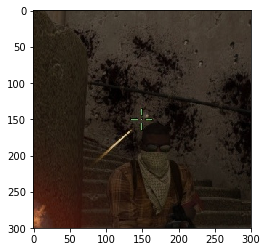

-------------------------------------------------------
Label: 1
Prediction 0.48947528


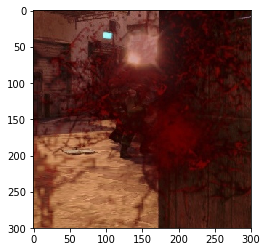

-------------------------------------------------------
Label: 1
Prediction 0.99999905


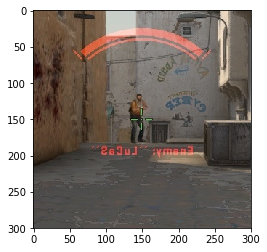

-------------------------------------------------------
Label: 1
Prediction 0.48760086


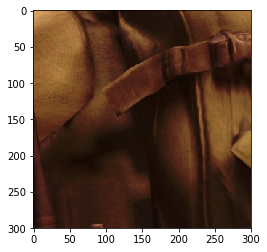

-------------------------------------------------------
Label: 1
Prediction 0.9105903


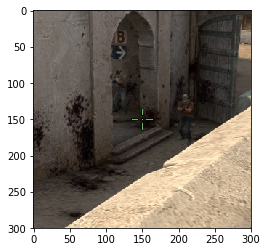

-------------------------------------------------------
Label: 1
Prediction 0.49351394


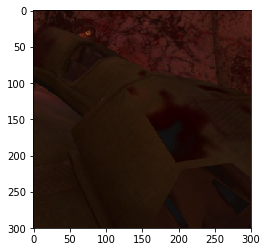

-------------------------------------------------------
Label: 1
Prediction 0.99832135


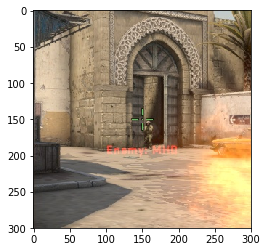

-------------------------------------------------------
Label: 1
Prediction 0.99819607


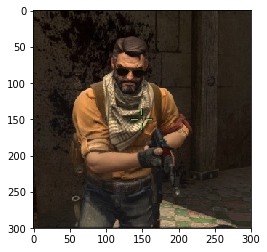

-------------------------------------------------------
Label: 1
Prediction 0.9999951


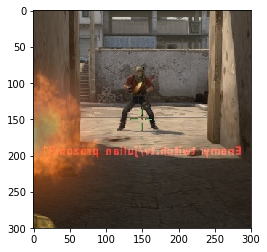

-------------------------------------------------------
Label: 1
Prediction 0.9614415


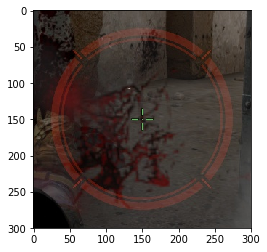

-------------------------------------------------------
Label: 1
Prediction 0.97658986


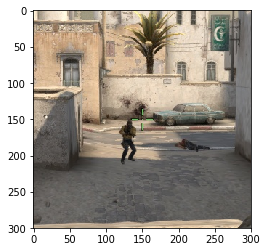

-------------------------------------------------------
Label: 1
Prediction 0.9997003


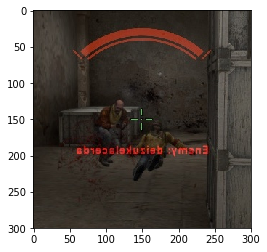

-------------------------------------------------------
Label: 1
Prediction 0.99999976


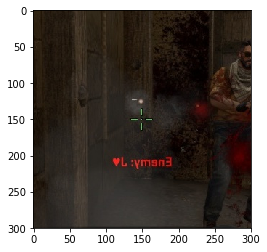

-------------------------------------------------------
Label: 1
Prediction 0.77833486


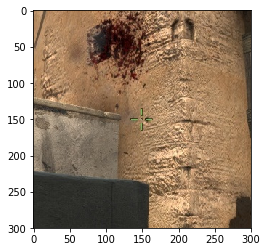

-------------------------------------------------------
Label: 1
Prediction 0.99275804


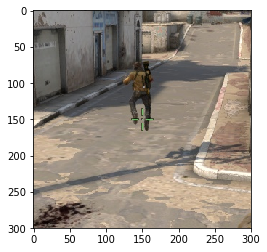

-------------------------------------------------------
Label: 1
Prediction 0.83263165


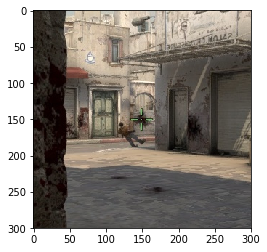

-------------------------------------------------------
Label: 1
Prediction 0.8216988


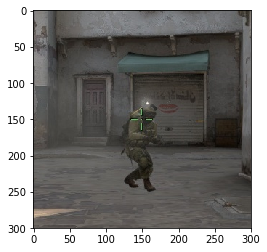

-------------------------------------------------------
Label: 1
Prediction 0.238753


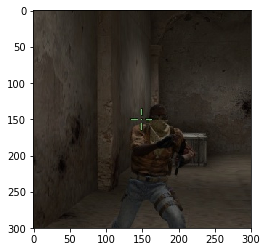

-------------------------------------------------------
Label: 1
Prediction 0.99062306


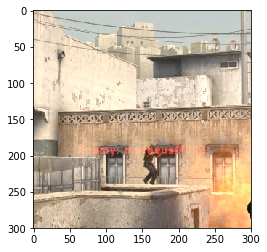

-------------------------------------------------------
Label: 1
Prediction 0.034092747


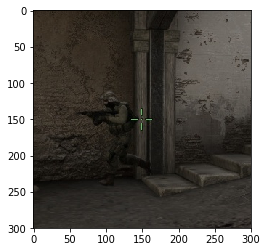

-------------------------------------------------------
Label: 1
Prediction 0.89087397


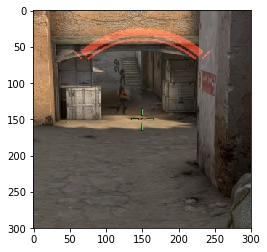

-------------------------------------------------------
Label: 1
Prediction 0.99740356


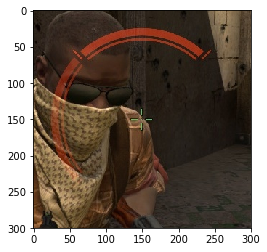

-------------------------------------------------------
Label: 1
Prediction 0.5705828


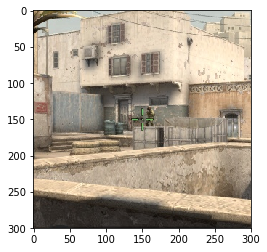

-------------------------------------------------------
Label: 1
Prediction 0.82373697


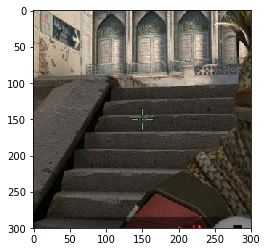

-------------------------------------------------------
Label: 1
Prediction 0.2023296


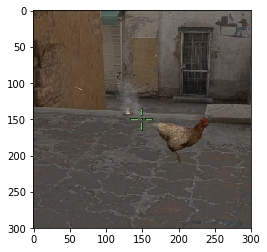

-------------------------------------------------------
Label: 1
Prediction 0.9471189


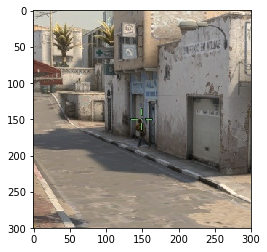

-------------------------------------------------------
Label: 1
Prediction 0.99993515


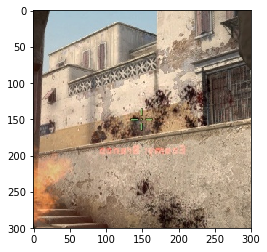

-------------------------------------------------------
Label: 1
Prediction 0.5824121


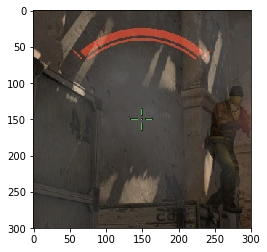

-------------------------------------------------------
Label: 1
Prediction 0.9663517


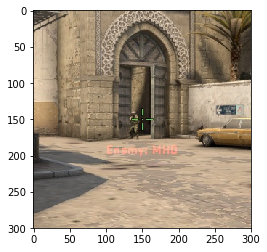

-------------------------------------------------------
Label: 1
Prediction 0.98660374


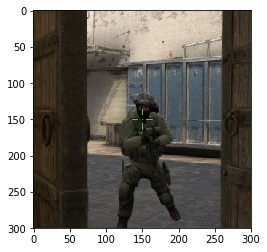

-------------------------------------------------------
Label: 1
Prediction 0.999998


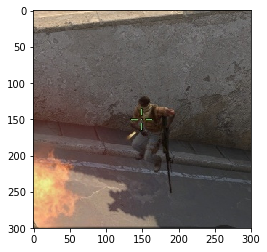

-------------------------------------------------------
Label: 1
Prediction 0.9756511


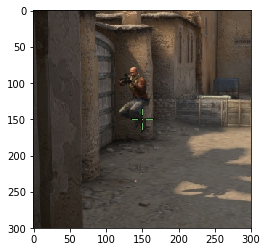

In [17]:
sample_files = np.random.choice(os.listdir("imgs"), size=128)

sample_imgs, sample_labels = list(zip(*[load_img("imgs/" + filename) for filename in sample_files]))

#Flip images horizontally
sample_preds = test_sess.run(outputs, feed_dict={ inputs: sample_imgs })

for sample_img, sample_label, sample_pred in zip(sample_imgs, sample_labels, sample_preds):
    
    if sample_label == 0:#if sample_label != int(sample_pred > 0.5):
        continue
        
    print("-------------------------------------------------------")
    print("Label: " + str(sample_label))
    print("Prediction " + str(sample_pred))
    plt.imshow(np.squeeze(sample_img))
    plt.show()

-------------------------------------------------------
Label: 0
Prediction 1.0


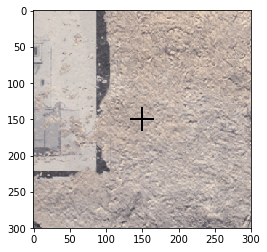

In [90]:
debug_img, debug_label = load_test_imgs("imgs/" + sample_files[-3])

#Corrupt img (hide aim)
aim_thickness = 1
aim_length = 16
#debug_img[150-offset:150+offset, 150-offset:150+offset, :] = 0
debug_img[150-aim_length:150+aim_length, 150-aim_thickness:150+aim_thickness, :] = 0
debug_img[150-aim_thickness:150+aim_thickness, 150-aim_length:150+aim_length, :] = 0


debug_pred = test_sess.run(outputs, feed_dict={ inputs: [debug_img] })[0]

print("-------------------------------------------------------")
print("Label: " + str(debug_label))
print("Prediction " + str(debug_pred))
plt.imshow(debug_img)
plt.show()